In [25]:
## Cell 1: Import Libraries and Setup
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set up display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")
## Cell 2: Get Stock Data and Explore
def get_stocks_data(symbols, start_date, end_date):
    """
    Get data for multiple stocks, however it rest of the code relies on a single stock's data structure.
    More testing & development to come for multi-stock support.
    """
    if isinstance(symbols, str):
        symbols = [symbols]  # Convert single string to list
    
    print(f"Getting data for {symbols} from {start_date} to {end_date}...")
    data = yf.download(symbols, start=start_date, end=end_date)
    print(f"Got {len(data)} days of data for {len(symbols)} stocks")
    
    # Flatten if only one stock to keep it simple
    if len(symbols) == 1:
        data = data.droplevel(1, axis=1)
    
    return data

def plot_stock_data(data, ticker):
    """
    Plot the closing price of the stock data.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], linewidth=2)
    plt.title(f'{ticker} Stock Price Over Last Year')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    plt.show()

Libraries imported successfully!


In [ ]:
## Function 2: Define and Test Dip Buying Strategy
def dip_buying_strategy(data, daily_budget=10, dip_threshold=0.10):
    """
    Buy when stock drops by dip_threshold (default 10%) from recent peak
    Money accumulates daily until a dip occurs
    """
    cash = 0
    shares = 0
    transactions = []
    daily_values = pd.Series(dtype=float)

    # Track the highest price seen so far (rolling peak)
    peak_price = data['Close'].iloc[0]
    
    print(f"Running Dip Buying Strategy:")
    print(f"- Daily budget: ${daily_budget}")
    print(f"- Dip threshold: {dip_threshold*100}%")
    print(f"- Starting peak price: ${peak_price:.2f}")
    print()
    
    for i, (date, row) in enumerate(data.iterrows()):
        current_price = row['Close']
        cash += daily_budget  # Add daily budget
        
        # Update peak price if current price is higher
        if current_price > peak_price:
            peak_price = current_price
        
        # Check if current price is below the dip threshold
        dip_price = peak_price * (1 - dip_threshold)
        
        if current_price <= dip_price and cash >= current_price:
            # Buy as many shares as possible with accumulated cash
            shares_to_buy = int(cash / current_price)
            # Remove this redundant check: if shares_to_buy > 0:
            
            cost = shares_to_buy * current_price
            cash -= cost
            shares += shares_to_buy
            
            dip_percent = ((peak_price - current_price) / peak_price) * 100
            
            transactions.append({
                'Date': date,
                'Price': current_price,
                'Shares': shares_to_buy,
                'Cost': cost,
                'Peak': peak_price,
                'Dip_Percent': dip_percent
            })
            
            print(f"{date.strftime('%Y-%m-%d')}: Bought {shares_to_buy} shares at ${current_price:.2f}")
            print(f"   -> {dip_percent:.1f}% dip from peak of ${peak_price:.2f}")
            print(f"   -> Spent ${cost:.2f}, Cash remaining: ${cash:.2f}")
            print()
            peak_price = current_price

        # Calculate total portfolio value
        portfolio_value = cash + (shares * current_price)
        daily_values.at[date] = portfolio_value

    total_invested = len(data) * daily_budget
    final_value = cash + (shares * data['Close'].iloc[-1])
    
    return {
        'daily_values': daily_values,
        'transactions': transactions,
        'final_value': final_value,
        'total_invested': total_invested,
        'cash_remaining': cash,
        'shares': shares
    }


_______________________________________________________________________________________________________________________________________________________________________________________

# Testing Area

In [ ]:
#variable initialization
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
symbol = 'VFV.TO'



In [ ]:
# Testing Function 1
data = get_stocks_data(symbol, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))

# Explore the data
print("\nFirst 5 rows of data:")
print(data.head())

print(f"\nStock price range:")
print(f"Lowest: ${data['Close'].min():.2f}")
print(f"Highest: ${data['Close'].max():.2f}")
print(f"Average: ${data['Close'].mean():.2f}")

C:\Users\lippm\AppData\Local\Temp\ipykernel_19312\3685632997.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbols, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Getting data for ['VFV.TO'] from 2024-08-16 to 2025-08-16...
Got 251 days of data for 1 stocks

First 5 rows of data:
Price            Close        High         Low        Open  Volume
Date                                                              
2024-08-16  133.521423  133.828207  133.224530  133.293812  223900
2024-08-19  134.332916  134.332916  133.234422  133.600582  183600
2024-08-20  133.996429  134.639701  133.818303  134.194368  137600
2024-08-21  134.273529  134.540734  133.501616  134.055823  147500
2024-08-22  133.303711  134.837647  133.036506  134.649614  177700

Stock price range:
Lowest: $125.59
Highest: $158.58
Average: $144.86


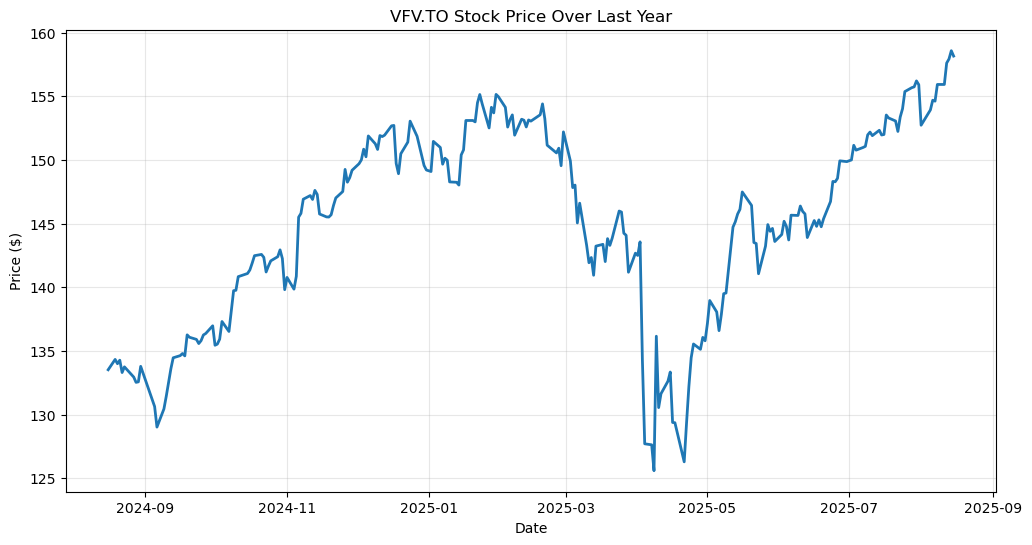

We'll be testing strategies on this 251-day period


In [28]:
## Plotting Function 1: Plot Stock Price to See What We're Working With
plot_stock_data(data, symbol)

print(f"We'll be testing strategies on this {len(data)}-day period")


In [29]:
# Test Function #2
# Test the dip buying strategy
daily_budget = 10  # $10 per day
dip_results = dip_buying_strategy(data, daily_budget=daily_budget, dip_threshold=0.05)

print("="*50)
print("="*50)
print("DIP BUYING STRATEGY RESULTS:")
print(f"Total money allocated: ${dip_results['total_invested']:,.2f}")
print(f"Final portfolio value: ${dip_results['final_value']:,.2f}")
print(f"Cash remaining: ${dip_results['cash_remaining']:.2f}")
print(f"Shares owned: {dip_results['shares']}")
print(f"Number of purchases: {len(dip_results['transactions'])}")

profit = dip_results['final_value'] - dip_results['total_invested']
profit_percent = (profit / dip_results['total_invested']) * 100
print(f"Profit: ${profit:,.2f} ({profit_percent:.1f}%)")


Running Dip Buying Strategy:
- Daily budget: $10
- Dip threshold: 5.0%
- Starting peak price: $133.52

2025-03-06: Bought 9 shares at $145.05
   -> 6.5% dip from peak of $155.15
   -> Spent $1305.48, Cash remaining: $84.52

2025-04-03: Bought 2 shares at $134.28
   -> 8.4% dip from peak of $146.60
   -> Spent $268.56, Cash remaining: $15.97

2025-04-22: Bought 1 shares at $129.31
   -> 5.0% dip from peak of $136.15
   -> Spent $129.31, Cash remaining: $6.65

DIP BUYING STRATEGY RESULTS:
Total money allocated: $2,510.00
Final portfolio value: $2,704.57
Cash remaining: $806.65
Shares owned: 12
Number of purchases: 3
Profit: $194.57 (7.8%)


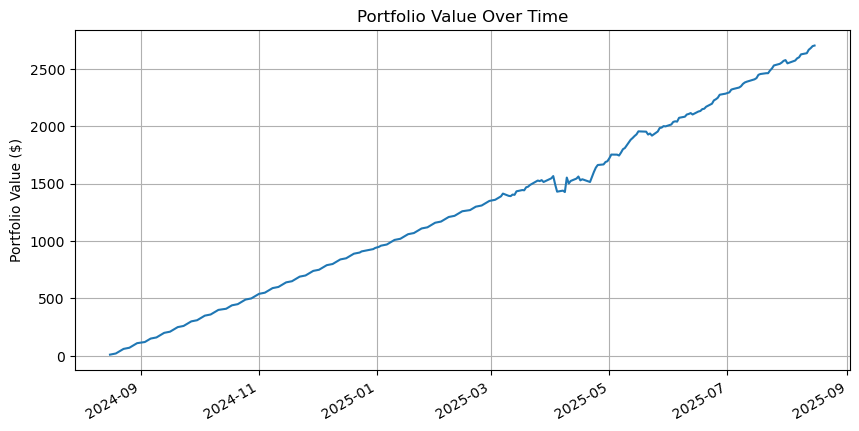

In [30]:
# plotting daily values:
dip_results['daily_values'].plot(figsize=(10, 5), title="Portfolio Value Over Time", ylabel="Portfolio Value ($)")
plt.grid(True)
plt.show()

In [31]:
print(type(dip_results['daily_values']))

<class 'pandas.core.series.Series'>


In [32]:
print((dip_results['daily_values']))

2024-08-16      10.000000
2024-08-19      20.000000
2024-08-20      30.000000
2024-08-21      40.000000
2024-08-22      50.000000
                 ...     
2025-08-11    2637.814117
2025-08-12    2667.974213
2025-08-13    2681.814117
2025-08-14    2699.614227
2025-08-15    2704.574249
Length: 251, dtype: float64
